# Combine predictors using stacking

Stacking refers to a method to blend estimators. In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators.

# 1. Import necessary libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

# 2. Load the data

In [96]:
def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X.loc[:, features]
    X, y = shuffle(X, y, random_state=0)

    X = X.iloc[:600]
    y = y.iloc[:600]
    return X, np.log(y)

In [97]:
X, y = load_ames_housing()

In [99]:
X.head()

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
529,2007,TA,Pave,1975,GasA,NaN,816,PConc,NaN,20,Gd,Norm,2,Attchd,6,2035,1219,1Story,NaN,3
491,2006,TA,Pave,1950,GasA,None,238,CBlock,0.0,50,TA,Norm,1,Attchd,6,806,403,1.5Fin,NaN,8
459,2009,TA,Pave,1950,GasA,BrkCmn,524,CBlock,161.0,50,TA,Norm,1,Detchd,5,709,185,1.5Fin,NaN,7
279,2008,Ex,Pave,1977,GasA,BrkFace,768,CBlock,299.0,60,TA,Norm,2,Attchd,7,1160,392,2Story,NaN,3
655,2010,TA,Pave,1971,GasA,BrkFace,525,CBlock,381.0,160,TA,Norm,1,Detchd,6,525,0,2Story,NaN,3


In [101]:
y.head()

,SalePrice
529,12.209188
491,11.798104
459,11.608236
279,12.165251
655,11.385092


In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 529 to 272
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YrSold        600 non-null    int64  
 1   HeatingQC     600 non-null    object 
 2   Street        600 non-null    object 
 3   YearRemodAdd  600 non-null    int64  
 4   Heating       600 non-null    object 
 5   MasVnrType    597 non-null    object 
 6   BsmtUnfSF     600 non-null    int64  
 7   Foundation    600 non-null    object 
 8   MasVnrArea    597 non-null    float64
 9   MSSubClass    600 non-null    int64  
 10  ExterQual     600 non-null    object 
 11  Condition2    600 non-null    object 
 12  GarageCars    600 non-null    int64  
 13  GarageType    562 non-null    object 
 14  OverallQual   600 non-null    int64  
 15  TotalBsmtSF   600 non-null    int64  
 16  BsmtFinSF1    600 non-null    int64  
 17  HouseStyle    600 non-null    object 
 18  MiscFeature   14 non-null     obj

In [103]:
X.describe()

,YrSold,YearRemodAdd,BsmtUnfSF,MasVnrArea,MSSubClass,GarageCars,OverallQual,TotalBsmtSF,BsmtFinSF1,MoSold
count,600.000000,600.000000,600.000000,597.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,2007.808333,1985.083333,559.276667,105.118928,57.791667,1.756667,6.098333,1043.598333,442.966667,6.440000
std,1.293981,20.881726,448.951451,184.362417,42.944600,0.771436,1.418456,469.242942,486.369631,2.750577
min,2006.000000,1950.000000,0.000000,0.000000,20.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,2007.000000,1965.750000,212.000000,0.000000,20.000000,1.000000,5.000000,777.750000,0.000000,5.000000
50%,2008.000000,1995.000000,463.500000,0.000000,50.000000,2.000000,6.000000,989.000000,378.000000,6.000000
75%,2009.000000,2004.000000,793.250000,160.000000,70.000000,2.000000,7.000000,1293.750000,714.500000,8.000000
max,2010.000000,2010.000000,2336.000000,1378.000000,190.000000,4.000000,10.000000,6110.000000,5644.000000,12.000000


In [104]:
X.describe(include='O')

,HeatingQC,Street,Heating,MasVnrType,Foundation,ExterQual,Condition2,GarageType,HouseStyle,MiscFeature
count,600,600,600,597,600,600,600,562,600,14
unique,4,2,5,4,6,4,7,5,8,2
top,Ex,Pave,GasA,None,CBlock,TA,Norm,Attchd,1Story,Shed
freq,313,599,587,356,265,384,591,348,292,13


# 3. Define the pipeline to preprocess the data

### 3.a Select the categorical and numerical columns of the dataset to construct the first step of the pipeline

In [105]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

In [109]:
print(cat_selector(X))

['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation', 'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature']


In [110]:
print(num_selector(X))

['YrSold', 'YearRemodAdd', 'BsmtUnfSF', 'MasVnrArea', 'MSSubClass', 'GarageCars', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1', 'MoSold']


### 3.b  Encoding , Scaling and missing value imputation

design preprocessing pipelines which depends on the ending regressor. If the ending regressor is a linear model, one needs to one-hot encode the categories. If the ending regressor is a tree-based model an ordinal encoder will be sufficient. Besides, numerical values need to be standardized for a linear model while the raw numerical data can be treated as is by a tree-based model. However, both models need an imputer to handle missing values.

Design pipeline for tree based model

In [111]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

In [112]:
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0ae7fb50>)])

define the preprocessor used when the ending regressor is a linear model

In [113]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)

In [114]:
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0ae7fb50>)])

# 4. Stack of predictors on a single data set

It is sometimes tedious to find the model which will best perform on a given dataset. Stacking provide an alternative by combining the outputs of several learners, without the need to choose a model specifically. The performance of stacking is usually close to the best model and sometimes it can outperform the prediction performance of each individual model.

Here, we combine 3 learners (linear and non-linear) and use a ridge regressor to combine their outputs together.

Note :  Although we will make new pipelines with the processors which we wrote in the previous section for the 3 learners, the final estimator RidgeCV() does not need preprocessing of the data as it will be fed with the already preprocessed output from the 3 learners.

### 4.a : 1st model is a LassoCV

In [115]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())

In [116]:
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0ae7fb50>)])),
                ('lassocv', LassoCV())])

### 4.b : 2nd model is a Random Forest regressor

In [117]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))

In [118]:
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0ae7fb50>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

### 4.c : 3rd model is a HistGradientBoostingRegressor

In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)

In [120]:
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0ae7fb50>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

### 4.d Stacking the 3 models using RidgeCV

In [121]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

In [122]:
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0afd6680>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7dcb0ae7fb50>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

# 5. Measure and plot the results

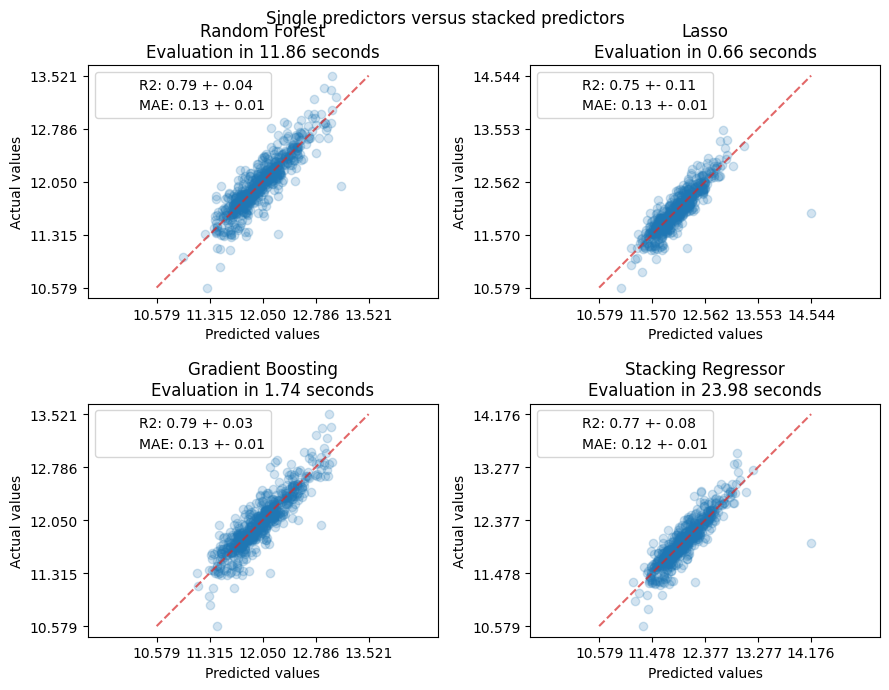

In [123]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The stacked regressor will combine the strengths of the different regressors. However, we also see that training the stacked regressor is much more computationally expensive.